## Spherical Splines based on Jupp & Kent (1987)

This notebook implements the algorithm for fitting splines introdiced in [Fitting Smooth Paths to Spherical Data](https://www.jstor.org/stable/2347843). The same implements a series of projections of spherical data to the 2D plane and then applies splines fit there. 

In [2]:
import pandas as pd
import numpy as np
import os
import cartopy.crs as ccrs
import pmagpy.ipmag as ipmag

from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 20)

from utils.spherical_splines import *

In [3]:
%load_ext autoreload
%autoreload 2

As an example, we are going to use the same example the authors use in the paper. Something that is not clear is what to do with points with same age. Traditional splines methods don't allow to use more than one data point per same age/dependent variable. 

In [4]:
example = 'real_poles'
#example = 'toy'

if example == 'real_poles':

    df = pd.read_csv('data/df_pole_compilation_by_study.csv', encoding="cp1254")
    df['Time'] = df['mean_age']
    df['Lat'] = - df['Plat'] # reverse latitude to coincide with north pole following the defaul to Jupp
    df['Lon'] = df['Plon']
    df = df[['Time', "Lat", 'Lon']]
    df.loc[df.shape[0]] = [0, 90., 0]

    # Add cartesian coordinates
    df['x'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[0], axis=1) 
    df['y'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[1], axis=1) 
    df['z'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[2], axis=1) 

    df = df.sort_values(by='Time')

elif example == 'toy':  
    
    df = pd.read_csv('data/Jupp-etal-1987_dataset.csv', encoding="cp1254")
    # We also manually add a fixed point in the origin of coordinates 
    df.loc[df.shape[0]] = ['Origin', 0, 90., 0]

    # In order to do splines, we need the time coordinate to be strictly increasing. This is a little bit annoying, so for now
    # we replace poles with same age by picking the first one in the age
    df = df.groupby(['Time']).first().reset_index()
    #df['Time'] += np.random.normal(0, 0.001, df.shape[0])
    df['Lat'] = 90 - df['Time'] * 0.1
    df['Lon'] = df['Time'] * 0.5 

    # Add cartesian coordinates
    df['x'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[0], axis=1) 
    df['y'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[1], axis=1) 
    df['z'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[2], axis=1) 

    df = df.sort_values(by='Time')
    # Filter the last points that for some reason are crashing the method
    #df = df[df['Time'] < 400]
    
df

,Time,Lat,Lon,x,y,z
31,0.0000,90.000000,0.000000,6.123234e-17,0.000000,1.000000
14,0.3555,83.095837,42.690352,8.835705e-02,0.081506,0.992749
12,0.3870,87.664063,11.142714,3.999016e-02,0.007877,0.999169
28,0.7635,85.421918,263.872370,-8.520016e-03,-0.079362,0.996809
3,0.7670,80.164116,314.290252,1.192871e-01,-0.122280,0.985301
7,1.0700,73.775957,249.302652,-9.874667e-02,-0.261362,0.960177
6,1.1050,84.889461,298.871431,4.301070e-02,-0.078006,0.996025
29,1.8950,87.135817,218.526712,-3.909133e-02,-0.031124,0.998751
24,2.0550,80.838128,336.592990,1.461211e-01,-0.063253,0.987242
5,2.2550,88.503095,154.996894,-2.367484e-02,0.011041,0.999659


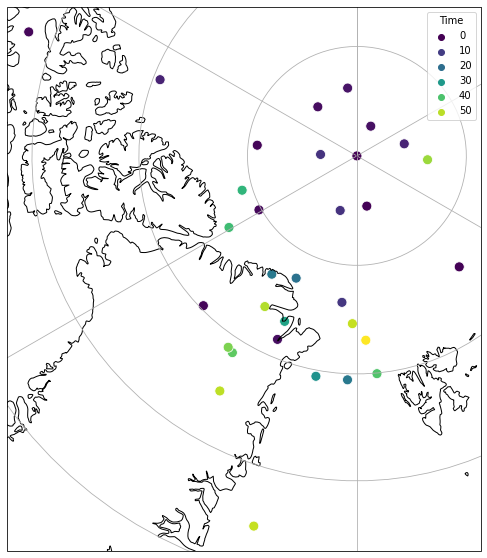

In [6]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=90))

ax.coastlines()
ax.gridlines()

sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=100,
                palette="viridis",
                transform = ccrs.PlateCarree());

## Experiment

In [7]:
%%time 

log_smoothings = np.linspace(-4, -2, 10)
smoothings = 10 ** log_smoothings
#smoothings = [0.01]

all_curves = {}

for s in smoothings:
    
    print("Running smoothing = ", s)
    
    final_curve = spherical_spline(times=df.Time.values,
                                   knot_values=df[['x','y','z']].values,
                                   smoothing=s,
                                   precision=0.1,
                                   ode_stepsize=0.01,    # never pick less than 0.01
                                   n_iter=5)
    all_curves[s] = final_curve

Running smoothing =  0.0001
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.0001668100537200059
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.0002782559402207126
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.00046415888336127773
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.000774263682681127
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.001291549665014884
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.002154434690031882
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.003593813663804626
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.005994842503189409
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.01
Maximul tolerance reached after a total of 5 iterations.
CPU times: user 44.6 s, sys: 30.4 ms

Smooth:  0.00046415888336127773


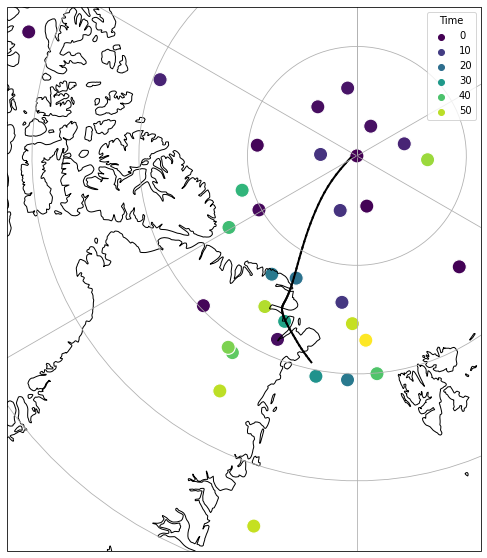

In [15]:
all_keys = list(all_curves.keys())
idx = 3
s = all_keys[idx]
print('Smooth: ', s)

curve = all_curves[s]

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=90))

ax.coastlines()
ax.gridlines()

# the first point is just noise... 
sph_splines = curve.knot_values[1:]

knot_values_sph = cart2sph(sph_splines, radians=False)[::10,:]

for i in range(knot_values_sph.shape[0]-1):
    plt.plot([knot_values_sph[i,0], knot_values_sph[i+1,0]], 
             [knot_values_sph[i,1], knot_values_sph[i+1,1]],
             linewidth=2, color='black',
             transform = ccrs.Geodetic())


sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=200,
                palette="viridis",
                transform = ccrs.PlateCarree());